# Hot Hand dans les parties d’échecs en ligne

Ce notebook étudie l’existence d’un effet de *Hot Hand* dans des parties d’échecs en ligne, entendu comme :

> **une victoire augmente-t-elle la probabilité de gagner la partie suivante ?**

L’analyse s’appuie sur des séquences de parties jouées par les mêmes joueurs. Elle progresse en quatre étapes :
1. **Dépendances brutes** entre résultats consécutifs (global, par format, par niveau).
2. **Proximité temporelle** : distinction entre simples parties “consécutives” et vraies séquences **intra-session**.
3. **Mémoire** : test de dépendance à court terme via une approche markovienne (ordre 1 vs ordre 2) sur les sessions.
4. **Contrôles et mécanismes** : régressions (niveau, couleur), fatigue, répétition d’ouverture, et test par permutation (null model).

> 💡 **Note de lecture**  
> Le notebook est conçu pour être lisible comme un rapport : chaque résultat important est commenté juste après le tableau ou le graphique correspondant.

## Sommaire

- **I. Récupération, préparation et prise en main des données**
  - I.1 Fonctions utilitaires
  - I.2 Chargement et nettoyage
  - I.3 Statistiques descriptives
- **II. Dépendances brutes**
  - II.1 Résultats consécutifs (test global)
  - II.2 Par format de partie
  - II.3 Par niveau (tranches de rating)
- **III. Proximité temporelle et sessions de jeu**
  - III.1 Définition d’une session
  - III.2 Comparaison : brut vs intra-session
  - III.3 Lecture et implications
- **IV. Mémoire intra-session : analyse markovienne**
  - IV.1 Probabilités conditionnelles (ordre 2)
  - IV.2 Test formel : ordre 1 vs ordre 2
  - IV.3 Interprétation
- **V. Contrôles et mécanismes**
  - V.1 Régression logistique (niveau, couleur)
  - V.2 Fatigue et dynamique de session
  - V.3 Ouverture rejouée
  - V.4 Null model (permutation)
  - V.5 Conclusion de section
- **Conclusion générale**


## Installation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.formula.api as smf
import statsmodels.api as sm
import os
import s3fs

## I. Récupération, préparation et prise en main des données 

### I.1 Fonctions utilitaires

In [2]:
# === CHARGEMENT DES DONNÉES ===
def load_games_from_s3(bucket, prefix, filename):
    endpoint = os.getenv("AWS_S3_ENDPOINT", "minio.lab.sspcloud.fr")
    s3_url = f"https://{endpoint}"
    storage_options = {"client_kwargs": {"endpoint_url": s3_url}}
    path = f"s3://{bucket}/{prefix}/{filename}"
    return pd.read_parquet(path, storage_options=storage_options)


# === NETTOYAGE DE BASE ===
def clean_games(df):
    if "game_id" in df.columns:
        df = df.drop_duplicates(subset=["user_id", "game_id"])
    else:
        df = df.drop_duplicates(subset=["user_id", "timestamp"])

    if "timestamp" not in df.columns and "timestamp_ms" in df.columns:
        df = df.copy()
        df.loc[:, "timestamp"] = df["timestamp_ms"]

    df = df.sort_values(["user_id", "timestamp"])
    df = df[df["result"] != "Draw"].copy()

    df["win"] = (df["result"] == "Win").astype(int)
    df["win_next"] = df.groupby("user_id")["win"].shift(-1)

    return df



# === TRANSITIONS & TESTS ===
def transition_table(df, col="win"):
    table = pd.crosstab(df[col], df[f"{col}_next"])
    probs = table.div(table.sum(axis=1), axis=0)
    return table, probs


def chi2_pvalue(df, col_x, col_y):
    table = pd.crosstab(df[col_x], df[col_y])
    if table.shape == (2, 2):
        return chi2_contingency(table)[1]
    return np.nan


### I.2 Chargement et préparation des données

In [3]:
df_all = load_games_from_s3(
    bucket="tristant",
    prefix="diffusion",
    filename="dfs_games.parquet"
)

n_before = len(df_all)
df_all = clean_games(df_all)
n_after = len(df_all)

print(f"Nombre de parties supprimées (nuls et doublons) : {n_before - n_after}")
print(f"Nombre de parties restantes : {n_after}")

df_valid = df_all.dropna(subset=["win_next"])


Nombre de parties supprimées (nuls et doublons) : 1223
Nombre de parties restantes : 35062


Avant d’analyser l’effet Hot Hand, nous effectuons quelques étapes de préparation :

- Tri et déduplication : les parties sont triées par joueur et chronologiquement, et les doublons sont supprimés.

- Codage des résultats : victoire = 1, défaite = 0. Les parties nulles (Draws) sont supprimées pour simplifier le calcul du résultat suivant. Cette simplification n'est bien sûre pas optimale en termes d'analyse mais concerne moins de 5% des parties et simplifie grandement les analyses qui vont suivre.

>⚠️ Exemple : une séquence Win → Draw → Win est comptée comme Win → Win. Les streaks réels sont donc légèrement modifiés.

- Création de win_next : pour chaque joueur, cette colonne correspond au résultat de la partie suivante. Les dernières parties sans win_next sont retirées.

À ce stade, nous ne regardons pas encore les streaks exacts, mais seulement la dépendance entre résultats consécutifs.

### I.3 Prise en main des données

Avant de procéder aux analyses statistiques, nous présentons brièvement
les principales caractéristiques du jeu de données utilisé.

In [4]:
# Nombre total de parties, joueurs et transitions valides
n_games = len(df_all)
n_players = df_all["user_id"].nunique()
n_transitions = len(df_valid)

print(f"Nombre total de parties : {n_games}")
print(f"Nombre de joueurs uniques : {n_players}")
print(f"Nombre de transitions valides (win_next défini) : {n_transitions}")

# Répartition par format de partie
print("\nRépartition des parties par format :")
print(df_all["format_partie"].value_counts())

# Statistiques de rating
print("\nStatistiques des ratings des joueurs :")
print(df_all["rating"].describe())


Nombre total de parties : 35062
Nombre de joueurs uniques : 150
Nombre de transitions valides (win_next défini) : 34912

Répartition des parties par format :
format_partie
blitz        14671
bullet        9506
rapid         9388
classical     1497
Name: count, dtype: int64

Statistiques des ratings des joueurs :
count    35062.000000
mean      1428.009440
std        225.875818
min        677.000000
25%       1261.000000
50%       1450.000000
75%       1596.000000
max       2249.000000
Name: rating, dtype: float64


Le jeu de données contient un nombre suffisant de données pour l'analyse cependant il y a un nombre inférieur de parties bullet et surtout classical, on pourra garder cela en tête pour le reste de l'analyse.

In [5]:
games_per_player = df_all.groupby("user_id").size()

games_per_player.describe(percentiles=[0.1, 0.5, 0.9, 0.99])


count    150.000000
mean     233.746667
std      107.739506
min        1.000000
10%      113.000000
50%      239.000000
90%      360.400000
99%      443.000000
max      472.000000
dtype: float64

Le jeu de données comprend 35 062 parties jouées par 140 joueurs distincts,
soit en moyenne environ 233 parties par joueur (médiane : 239).

La distribution du nombre de parties par joueur est relativement homogène,
sans asymétrie marquée ni individus dominant excessivement l’échantillon
(nombre maximum de parties par joueur : 237).

Cette structure équilibrée constitue un cadre favorable à l’analyse des
dépendances entre résultats consécutifs, en limitant le risque que les
résultats soient entraînés par un petit nombre de joueurs très actifs.

## II. Dépendances brutes

### II.1 Dépendance brute entre résultats consécutifs

Nous comparons la probabilité de gagner la partie N+1 selon que la partie N ait été gagnée ou perdue.


In [6]:
table, probs = transition_table(df_valid)
p_value = chi2_pvalue(df_valid, "win", "win_next")

probs, p_value


(win_next       0.0       1.0
 win                         
 0         0.519902  0.480098
 1         0.488700  0.511300,
 np.float64(5.907329382684101e-09))

On observe une probabilité de victoire à N+1 plus élevée après une victoire qu’après une défaite.

Le test du χ² rejette très fortement l’hypothèse d’indépendance entre les résultats consécutifs (p-value < 0,01).

Cependant, cette dépendance brute peut toutefois s’expliquer par des facteurs structurels
(niveau relatif des joueurs, rematchs, sessions de jeu) et ne constitue pas encore une preuve d’un effet *Hot Hand*.


### II.2 Dépendance brute selon le format de partie

Nous analysons maintenant si la probabilité de gagner la partie suivante dépend du résultat précédent, **en distinguant les formats de partie** (bullet, blitz, rapid, classical).

> On compare P(Victoire N+1 | Victoire N) et P(Victoire N+1 | Défaite N) pour chaque type de format.


#### II.2.A Probabilité de victoire à N+1 selon le résultat précédent et calcul de la p-value

In [7]:
# Probabilités conditionnelles par format
probs_by_format = (
    df_valid
    .groupby(["format_partie", "win"])["win_next"]
    .mean()
    .unstack()
)

print("Probabilités de victoire à N+1 selon le résultat précédent :")
print(probs_by_format)

# Test χ² par format
print("\nTest d'indépendance χ² par format :")
for fmt, df_fmt in df_valid.groupby("format_partie"):
    p_val = chi2_pvalue(df_fmt, "win", "win_next")
    print(f"Format {fmt} - p-value χ² : {p_val:.3e}")


Probabilités de victoire à N+1 selon le résultat précédent :
win                   0         1
format_partie                    
blitz          0.486096  0.508685
bullet         0.477324  0.496615
classical      0.456873  0.549669
rapid          0.477253  0.523446

Test d'indépendance χ² par format :
Format blitz - p-value χ² : 6.689e-03
Format bullet - p-value χ² : 6.364e-02
Format classical - p-value χ² : 4.022e-04
Format rapid - p-value χ² : 8.532e-06


En distinguant les formats, la dépendance entre le résultat en N et en N+1 reste significative pour blitz (p≈0,0069), rapid (p≈8.5xe-6) et classical (p≈4.0xe-4) : la probabilité de gagner en N+1 est systématiquement plus élevée après une victoire qu’après une défaite.

Le bullet fait exception : l’écart va dans le même sens (0,4966 vs 0,4773) mais n’est pas significatif au seuil de 5 % (p≈0,064), possiblement faute d’observations suffisantes et/ou du fait d’une plus grande variabilité dans ce format.

#### II.2.B Visualisation

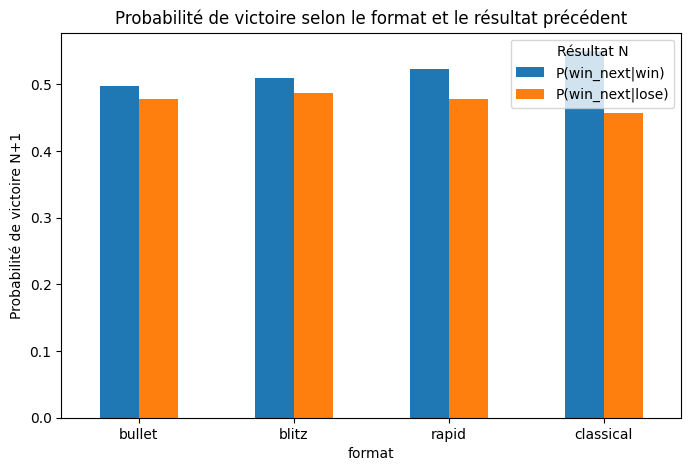

In [8]:
format_order = ["bullet", "blitz", "rapid", "classical"]

# Préparer le DataFrame pour le graphique
prob_df = []
for fmt in format_order:
    if fmt in probs_by_format.index:
        prob_df.append({
            "format": fmt,
            "P(win_next|win)": probs_by_format.loc[fmt, 1],
            "P(win_next|lose)": probs_by_format.loc[fmt, 0]
        })

prob_df = pd.DataFrame(prob_df)

# Graphique simple
prob_df.set_index("format")[["P(win_next|win)", "P(win_next|lose)"]].plot(
    kind="bar", figsize=(8,5), color=["#1f77b4", "#ff7f0e"]
)
plt.ylabel("Probabilité de victoire N+1")
plt.title("Probabilité de victoire selon le format et le résultat précédent")
plt.xticks(rotation=0)
plt.legend(title="Résultat N")
plt.show()

### II.3 Dependance brute selon le niveau du joueur

Nous analysons maintenant si la probabilité de gagner la partie suivante dépend du résultat précédent, **en distinguant le niveau du joueur de partie** que nous classerons dans différents *rating bin*.

> On compare P(Victoire N+1 | Victoire N) et P(Victoire N+1 | Défaite N) pour chaque *rating bin*.



In [9]:
df_all['rating_bin'] = pd.qcut(df_all['rating'], q=8, duplicates='drop')

df_all['rating_bin'].value_counts().sort_index()


rating_bin
(676.999, 1146.0]    4423
(1146.0, 1261.0]     4369
(1261.0, 1358.0]     4398
(1358.0, 1450.0]     4388
(1450.0, 1525.0]     4372
(1525.0, 1596.0]     4387
(1596.0, 1677.0]     4371
(1677.0, 2249.0]     4354
Name: count, dtype: int64

#### II.3.A Probabilité de victoire à N+1 selon le résultat précédent

On calcule la probabilité qu'un joueur gagne la partie suivante en fonction de s'il a gagné ou perdu la précédente, pour chaque tranche de niveau.


In [10]:
# Reconstruction df_valid
df_valid = df_all.dropna(subset=["win_next"])

# Probabilités conditionnelles par tranche de rating
df_plot = (
    df_valid.groupby(["rating_bin", "win"], observed=True)["win_next"]
            .mean()
            .reset_index()
)
df_plot["win_label"] = df_plot["win"].map({0: "Défaite précédente", 1: "Victoire précédente"})

# Calcul des p-values χ² par tranche de rating
p_values_rating = {}
for bin_label, df_bin in df_valid.groupby("rating_bin", observed = True):
    table = pd.crosstab(df_bin["win"], df_bin["win_next"])
    if table.shape == (2, 2):
        _, p_val, _, _ = chi2_contingency(table)
        p_values_rating[bin_label] = p_val
    else:
        p_values_rating[bin_label] = np.nan

# Affichage rapide
print("Probabilités de victoire à N+1 par tranche de rating :")
print(df_plot.pivot(index="rating_bin", columns="win_label", values="win_next"))

print("\nP-values χ² par tranche de rating :")
for bin_label, p_val in p_values_rating.items():
    print(f"{bin_label}: {p_val:.3e}")


Probabilités de victoire à N+1 par tranche de rating :
win_label          Défaite précédente  Victoire précédente
rating_bin                                                
(676.999, 1146.0]            0.466011             0.514774
(1146.0, 1261.0]             0.465710             0.513705
(1261.0, 1358.0]             0.483100             0.498141
(1358.0, 1450.0]             0.484612             0.519415
(1450.0, 1525.0]             0.493394             0.496529
(1525.0, 1596.0]             0.488200             0.533937
(1596.0, 1677.0]             0.479244             0.508716
(1677.0, 2249.0]             0.481115             0.504466

P-values χ² par tranche de rating :
(676.999, 1146.0]: 1.349e-03
(1146.0, 1261.0]: 1.726e-03
(1261.0, 1358.0]: 3.349e-01
(1358.0, 1450.0]: 2.324e-02
(1450.0, 1525.0]: 8.598e-01
(1525.0, 1596.0]: 2.752e-03
(1596.0, 1677.0]: 5.573e-02
(1677.0, 2249.0]: 1.311e-01


Globalement, dans toutes les tranches de rating, la probabilité de gagner en *N+1* est plus élevée après une victoire qu’après une défaite, mais l’effet est hétérogène selon le niveau.

- **Bas niveaux** (677–1146] et (1146–1261] : écart net (≈ +4 à +5 points) et statistiquement significatif (p ≈ 0,001–0,002).
- **Niveaux intermédiaires** : (1261–1358] et surtout (1450–1525] présentent un écart faible et non significatif (p ≈ 0,33 et 0,86).
- **Niveaux élevés** : l’effet réapparaît dans la tranche (1525–1596] avec un écart marqué et significatif (p ≈ 0,003), puis reste positif mais non significatif dans les tranches supérieures (p ≈ 0,056 et 0,13), possiblement en raison d’effectifs plus réduits et d’une performance plus stable.

Dans l’ensemble, la dépendance entre résultats consécutifs semble réelle mais non monotone avec le rating.


#### II.3.B Visualisation

On trace un graphique en barres montrant la probabilité de victoire à N+1 selon le résultat précédent pour chaque tranche de niveau.


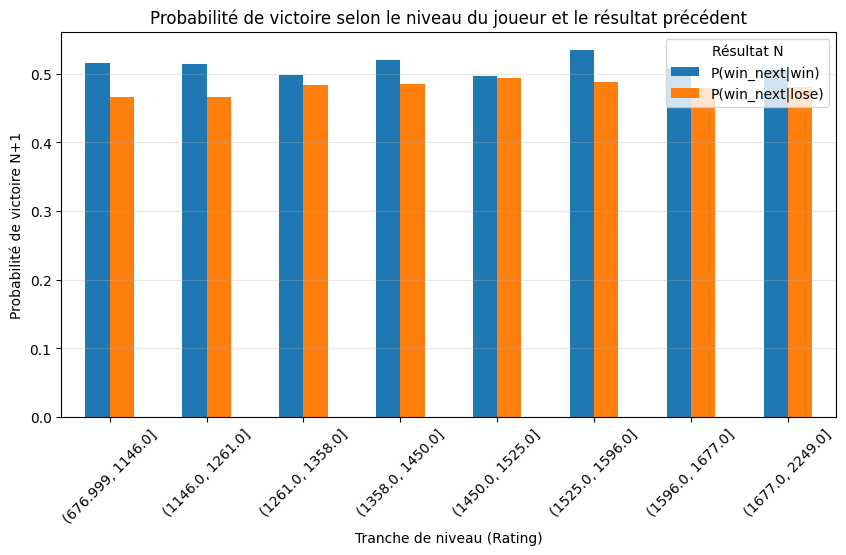

In [11]:
# --- Probabilités conditionnelles par tranche de rating ---
probs_by_rating = (
    df_all
    .groupby(["rating_bin", "win"], observed=True)["win_next"]
    .mean()
    .unstack()
)

# Préparer le DataFrame pour le graphique
rating_labels = [str(interval) for interval in probs_by_rating.index]
prob_df = []
for i, r in enumerate(probs_by_rating.index):
    prob_df.append({
        "rating_bin": rating_labels[i],
        "P(win_next|win)": probs_by_rating.loc[r, 1],
        "P(win_next|lose)": probs_by_rating.loc[r, 0]
    })

prob_df = pd.DataFrame(prob_df)

# Graphique
prob_df.set_index("rating_bin")[["P(win_next|win)", "P(win_next|lose)"]].plot(
    kind="bar", figsize=(10,5), color=["#1f77b4", "#ff7f0e"]
)
plt.ylabel("Probabilité de victoire N+1")
plt.xlabel("Tranche de niveau (Rating)")
plt.title("Probabilité de victoire selon le niveau du joueur et le résultat précédent")
plt.xticks(rotation=45)
plt.legend(title="Résultat N")
plt.grid(axis='y', alpha=0.3)
plt.show()


Même au sein des différentes tranches de niveau, on observe que la probabilité de gagner la partie suivante est plus élevée après une victoire précédente.  

## III. Proximité temporelle et sessions de jeu

L’effet *Hot Hand* est, par définition, un phénomène **local dans le temps** :  
il suppose que les performances récentes influencent les suivantes **à court terme**.

Dans les analyses précédentes, deux parties consécutives peuvent toutefois être séparées
de quelques secondes… ou de plusieurs jours. Traiter ces situations comme équivalentes
peut créer une dépendance artificielle ou, au contraire, diluer un effet réel.

L’objectif de cette section est donc de **restreindre l’analyse aux parties réellement
consécutives**, jouées dans une même session de jeu.


### III.1 Définition d’une session de jeu et autres variables

Nous définissons une *session de jeu* comme une suite de parties jouées par un même joueur,
séparées par **au plus 30 minutes** entre deux parties consécutives.

Ce seuil constitue un compromis :
- suffisamment court pour capturer des enchaînements intentionnels de parties ;
- suffisamment long pour inclure les pauses naturelles (analyse rapide, attente d’adversaire).

L’analyse repose avant tout sur une **comparaison avant / après filtrage temporel** :
le choix exact du seuil n’est donc pas déterminant.

Nous allons aussi définir de nouvelles variables et dataset filtrés qui nous seront utiles par la suite avant d'alléger la lecture. 

>**L'exécution de cette cellule est donc indispensable au fonctionnement de la suite du notebook :**

In [12]:
SESSION_GAP = 30  # minutes

# 1) Date + tri
df_all["date"] = pd.to_datetime(df_all["timestamp"], unit="ms")
df_all = df_all.sort_values(["user_id", "date"]).reset_index(drop=True)

# 2) Sessions
df_all["delta_minutes"] = (
    df_all.groupby("user_id")["date"].diff().dt.total_seconds() / 60
)
df_all["new_session"] = (df_all["delta_minutes"] > SESSION_GAP) | (df_all["delta_minutes"].isna())
df_all["session_id"] = df_all.groupby("user_id")["new_session"].cumsum()

# 3) Numéro de partie dans la session (pour fatigue)
df_all["game_in_session"] = df_all.groupby(["user_id", "session_id"]).cumcount() + 1

# 4) Transitions brutes et intra-session
df_all["win_next_brut"] = df_all.groupby("user_id")["win"].shift(-1)

df_all["delta_next_minutes"] = (
    (df_all.groupby("user_id")["date"].shift(-1) - df_all["date"])
    .dt.total_seconds() / 60
)
df_all["win_next_session"] = df_all.groupby("user_id")["win"].shift(-1)
df_all.loc[df_all["delta_next_minutes"] > SESSION_GAP, "win_next_session"] = pd.NA

# 5) Lags intra-session (pour Markov)
df_all["win_lag1"] = df_all.groupby(["user_id", "session_id"])["win"].shift(1)
df_all["win_lag2"] = df_all.groupby(["user_id", "session_id"])["win"].shift(2)

# 6) Couleur
df_all["is_white"] = (df_all["color"] == "white").astype(int)

# 7) Jeux de travail
df_brut = df_all.dropna(subset=["win_next_brut"]).copy()
df_session = df_all.dropna(subset=["win_next_session"]).copy()

df_intra = df_all.dropna(subset=["session_id"]).copy()
df_mk_sess = df_intra.dropna(subset=["win", "win_lag1", "win_lag2"]).copy()
df_mk_sess[["win_lag1", "win_lag2"]] = df_mk_sess[["win_lag1", "win_lag2"]].astype(int)

print("df_brut:", len(df_brut), "| df_session:", len(df_session), "| df_mk_sess:", len(df_mk_sess))

df_brut: 34912 | df_session: 20472 | df_mk_sess: 13571


### III.2 Comparaison : dépendance brute vs dépendance intra-session

Nous comparons maintenant la dépendance entre les résultats consécutifs :
- **sans contrainte temporelle** ;
- **en restreignant aux parties intra-session**.


In [13]:
# χ² brute
table_brut = pd.crosstab(df_brut["win"], df_brut["win_next_brut"])
_, p_value_brut, _, _ = chi2_contingency(table_brut)

# χ² intra-session
table_session = pd.crosstab(df_session["win"], df_session["win_next_session"])
_, p_value_session, _, _ = chi2_contingency(table_session)

summary_time = pd.DataFrame({
    "Cadre d'analyse": ["Sans contrainte temporelle", f"Intra-session (≤ {SESSION_GAP} min)"],
    "p-value χ²": [p_value_brut, p_value_session]
})
summary_time

,Cadre d'analyse,p-value χ²
0,Sans contrainte temporelle,5.907329e-09
1,Intra-session (≤ 30 min),1.639785e-05


### III.3 Lecture des résultats

La dépendance entre le résultat d’une partie et celui de la partie suivante
reste hautement significative lorsque l’on restreint l’analyse aux parties
jouées dans une même session (≤ 30 minutes).

Ce résultat indique que la dépendance observée précédemment ne provient pas
uniquement de parties consécutives éloignées dans le temps, mais qu’elle
s’exprime également au sein de séquences de jeu continues.

Le filtrage temporel ne vise pas à faire disparaître l’effet, mais à vérifier
qu’il persiste dans un cadre compatible avec l’hypothèse d’un effet *Hot Hand*
local dans le temps.



## IV. Mémoire intra-session : analyse markovienne

Dans la section précédente, nous avons montré que la dépendance entre résultats consécutifs
persiste lorsque l’on se restreint à des parties jouées **dans une même session** (≤ 30 minutes).

Nous testons maintenant une question plus précise :

> La dépendance intra-session est-elle **entièrement capturée par le dernier résultat** (Markov d’ordre 1),
> ou existe-t-il une **mémoire plus longue** (Markov d’ordre 2), c.-à-d. un effet cumulatif ?

Formellement : On compare deux hypothèses de mémoire :

- **Ordre 1** : le résultat à *t* dépend uniquement du match précédent (*t−1*).
- **Ordre 2** : le résultat à *t* dépend des deux matchs précédents (*t−1* et *t−2*)

Dans toute cette section, l’analyse est effectuée **uniquement sur les transitions intra-session**.



### IV.1 Probabilités conditionnelles (Markov ordre 2)

On regarde si le résultat d’une partie dépend des **deux résultats précédents**.

Pour chaque partie *t*, on code l’“historique” des deux matchs précédents (*t−2*, *t−1*) parmi 4 états possibles :
- `00` : défaite puis défaite
- `01` : défaite puis victoire
- `10` : victoire puis défaite
- `11` : victoire puis victoire

Pour chacun de ces états, on calcule ensuite la proportion de victoires à *t* :
**P(victoire à t | état passé)**.

> ⚠️ Cette étape est **descriptive** : elle sert à visualiser une éventuelle accumulation.
> La significativité statistique sera testée juste après en comparant l’ordre 1 et l’ordre 2.


In [14]:
state_order = ["00", "01", "10", "11"]

state2 = df_mk_sess.assign(
    state2=df_mk_sess["win_lag2"].astype(str) + df_mk_sess["win_lag1"].astype(str)
)

markov_table = (
    state2.groupby("state2")["win"]
          .agg(P_win="mean", n="size")
          .reindex(state_order)
)

markov_table


,P_win,n
state2,,
00,0.468599,3312
01,0.502438,3282
10,0.490677,3218
11,0.516095,3759


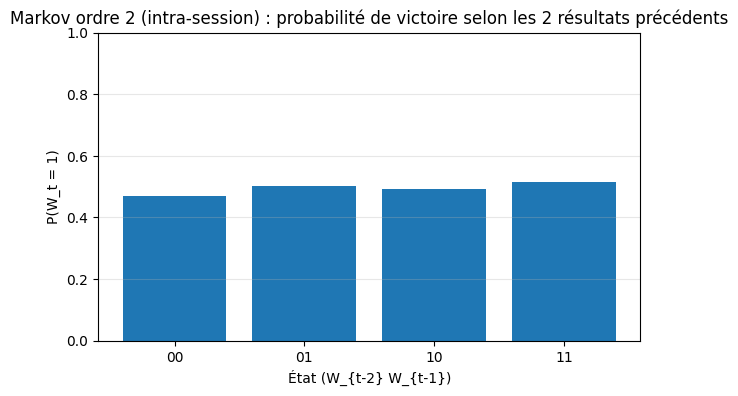

In [15]:
plt.figure(figsize=(7, 4))
plt.bar(markov_table.index, markov_table["P_win"])
plt.ylim(0, 1)
plt.xlabel("État (W_{t-2} W_{t-1})")
plt.ylabel("P(W_t = 1)")
plt.title("Markov ordre 2 (intra-session) : probabilité de victoire selon les 2 résultats précédents")
plt.grid(axis="y", alpha=0.3)
plt.show()


La probabilité de victoire augmente avec un historique plus favorable : minimale après `00`, intermédiaire après `01`/`10`, maximale après `11`. Cela est conforme à nos attentes cependant ces résultats restent descriptifs. La section suivante teste formellement si l’ordre 2 apporte un gain par rapport à l’ordre 1.


### IV.2 Test formel : Markov d’ordre 1 vs Markov d’ordre 2 (LR test)

Nous comparons deux modèles logistiques emboîtés :

- **M1 (ordre 1)** : la probabilité de gagner dépend uniquement du résultat précédent (`win_lag1`).
- **M2 (ordre 2)** : la probabilité de gagner dépend du résultat précédent (`win_lag1`) *et* de l’avant-dernier (`win_lag2`).

Si le modèle M2 améliore significativement l’ajustement, cela signifie que le résultat à *t−2*
apporte une information au-delà du seul résultat à *t−1* : il existe donc une mémoire
plus longue qu’un match.

Nous reportons également les critères **AIC** et **BIC**, qui pénalisent la complexité du modèle.


In [16]:
m1 = smf.logit("win ~ win_lag1", data=df_mk_sess).fit(disp=0)
m2 = smf.logit("win ~ win_lag1 + win_lag2", data=df_mk_sess).fit(disp=0)

LR = 2 * (m2.llf - m1.llf)
df_diff = m2.df_model - m1.df_model
p_lr = chi2.sf(LR, df_diff)

summary_models = pd.DataFrame({
    "Model": ["Order 1", "Order 2"],
    "LogLik": [m1.llf, m2.llf],
    "AIC": [m1.aic, m2.aic],
    "BIC": [m1.bic, m2.bic],
})

summary_models, {"LR": LR, "df": df_diff, "p_value": p_lr}

(     Model       LogLik           AIC           BIC
 0  Order 1 -9399.866382  18803.732763  18818.764144
 1  Order 2 -9397.739188  18801.478375  18824.025447,
 {'LR': np.float64(4.254387627319375),
  'df': 1.0,
  'p_value': np.float64(0.03914906036276101)})

### IV.3 Interprétation

Le test du rapport de vraisemblance indique que le modèle d’ordre 2 améliore
significativement l’ajustement par rapport au modèle d’ordre 1
(LR = 4,25 ; p-value ≈ 0,039).
Cela suggère que, même conditionnellement au dernier résultat,
l’avant-dernier match contient encore de l’information pour prédire l’issue
de la partie courante.

Toutefois, l’amélioration reste modeste : si le critère AIC favorise
l’ordre 2, le BIC privilégie l’ordre 1.
La mémoire intra-session apparaît donc légèrement supérieure à un match,
mais sans constituer une dynamique fortement persistante.


### IV. Conclusion de section

Au sein des sessions de jeu (parties rapprochées dans le temps), les résultats présentent
une **mémoire d’ordre 2** : les deux matchs précédents contribuent à expliquer la probabilité
de victoire, au-delà du seul dernier résultat.

Cette évidence statistique caractérise une dépendance temporelle plus longue qu’un match,
compatible avec l’idée d’un effet *Hot Hand* cumulatif à court terme.

La suite du notebook introduit des contrôles (niveau du joueur, couleur, fatigue/session)
afin d’évaluer dans quelle mesure cette mémoire peut être expliquée par des facteurs alternatifs.


## V. Contrôles et mécanismes

Après avoir mis en évidence une dépendance intra-session entre résultats consécutifs,
ainsi qu’une mémoire d’ordre 2, cette section poursuit deux objectifs :

1. **Tester la robustesse** de cette dépendance en contrôlant pour des facteurs observables.
2. **Explorer des mécanismes plausibles** susceptibles de générer cette dynamique,
   sans prétendre à une identification causale.

Cette section ne vise pas à “prouver” l’effet *Hot Hand*,
mais à vérifier qu’il ne se réduit pas à des artefacts évidents
et à proposer des interprétations compatibles avec les résultats observés.


### V.1 Contrôle statistique : régression logistique (niveau et couleur)

Même au sein des sessions, la dépendance observée pourrait s’expliquer par :
- le niveau intrinsèque du joueur ;
- un avantage structurel (jouer avec les Blancs).

Nous estimons donc un modèle logistique où la probabilité de victoire dépend :
- du résultat précédent ;
- du rating du joueur (proxy du niveau) ;
- de la couleur.

L’objectif est de vérifier si l’effet du résultat précédent persiste
*toutes choses égales par ailleurs*.


In [17]:
df_reg = df_mk_sess.dropna(subset=["rating", "is_white"]).copy()

model = smf.logit("win ~ win_lag1 + rating + is_white", data=df_reg).fit(disp=0)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                13571
Model:                          Logit   Df Residuals:                    13567
Method:                           MLE   Df Model:                            3
Date:                Mon, 29 Dec 2025   Pseudo R-squ.:                0.001387
Time:                        17:11:13   Log-Likelihood:                -9393.0
converged:                       True   LL-Null:                       -9406.1
Covariance Type:            nonrobust   LLR p-value:                 9.102e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2145      0.113     -1.897      0.058      -0.436       0.007
win_lag1       0.1228      0.034      3.565      0.000       0.055       0.190
rating      4.889e-05   7.75e-05      0.631      0.528      -0.000       0.000
is_white       0.1253      0.034      3.645      0.000       0.058       0.193
==============================================================================
"""

La régression logistique est estimée sur 12 033 observations intra-session.

Après contrôle du niveau du joueur (rating) et de la couleur, le résultat précédent reste
positivement associé à la probabilité de victoire : le coefficient de `win_lag1` est positif
et  significatif (coef ≈ 0,123 ; p < 0,001).

L’effet “Blancs” est également positif et significatif (coef ≈ 0,125 ; p < 0,001), ce qui est
cohérent avec un avantage structurel de la couleur.

En revanche, le rating n’apparaît pas significatif (coeff ≈ 0 ; p ≈ 0,53) dans ce modèle,
ce qui suggère que, dans cet échantillon intra-session, le niveau n’explique pas
la dépendance temporelle observée (ou qu’il est déjà partiellement neutralisé par le matchmaking).

Ainsi, l’association entre victoire récente et victoire suivante persiste même en tenant compte
de facteurs observables simples, ce qui renforce la robustesse du résultat.

### V.2 Dynamique de session : fatigue et relâchement

Une autre explication possible de la dépendance observée est une dynamique de session :
au fil des parties, la performance peut évoluer en raison de la fatigue,
du relâchement ou du tilt.

Nous examinons ici comment le taux de victoire évolue
en fonction de la position de la partie dans la session.


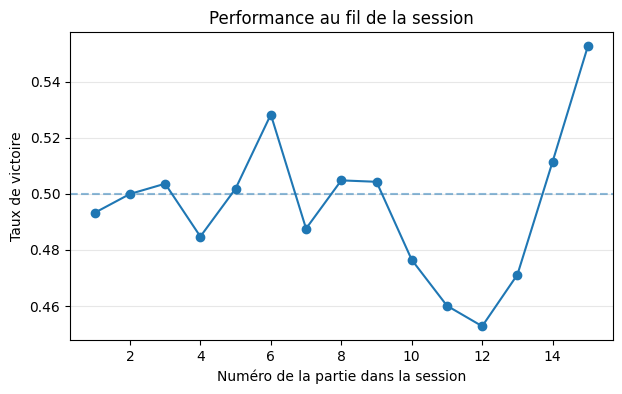

In [18]:
df_fatigue = df_intra.loc[df_intra["game_in_session"].le(15)]

rate_by_pos = df_fatigue.groupby("game_in_session")["win"].mean()

plt.figure(figsize=(7,4))
plt.plot(rate_by_pos.index, rate_by_pos.values, marker="o")
plt.axhline(0.5, linestyle="--", alpha=0.5)
plt.xlabel("Numéro de la partie dans la session")
plt.ylabel("Taux de victoire")
plt.title("Performance au fil de la session")
plt.grid(axis="y", alpha=0.3)
plt.show()

On observe une légère inflexion de la performance au cours des sessions, avec un creux autour de la 10ᵉ partie jouée, ce qui est compatible avec un effet de fatigue, de relâchement ou de tilt.

Le taux de victoire remonte ensuite assez nettement sur les dernières positions. Il serait tentant d’y voir un “rebond” après avoir tenu bon, mais cette lecture est très probablement trompeuse : plus on avance dans la session, plus on ne conserve que les sessions longues (et donc un sous-ensemble particulier de joueurs / moments), et surtout le nombre d’observations chute fortement.

Nous pouvons le vérifier directement en affichant, pour chaque rang dans la session, le nombre de parties utilisées pour calculer la moyenne :

In [19]:
fatigue_stats = (
    df_fatigue
    .groupby("game_in_session")
    .agg(
        win_rate=("win", "mean"),
        n_games=("win", "size")
    )
)

fatigue_stats

,win_rate,n_games
game_in_session,,
1,0.493215,14590
2,0.499928,6901
3,0.503595,3894
4,0.484737,2457
5,0.501838,1632
6,0.528269,1132
7,0.487574,845
8,0.504777,628
9,0.504274,468


Comme attendu, nous avons trop peu de parties pour les séries longues pour en tirer des conclusions pertinentes.

### V.3 Mécanisme comportemental : rejouer la même ouverture

Un mécanisme plausible de persistance des performances est l’adaptation des décisions.
Après une victoire, les joueurs peuvent être enclins à répéter une stratégie perçue
comme efficace.

Nous testons ici si la probabilité de rejouer la même ouverture
dépend du résultat de la partie précédente.


In [20]:
df_open = df_all.assign(
    same_opening_next=lambda d: d.groupby("user_id")["opening_name"].shift(-1).eq(d["opening_name"])
).dropna(subset=["win", "same_opening_next"])

prob_opening = df_open.groupby("win")["same_opening_next"].mean()

tab_open = pd.crosstab(df_open["win"], df_open["same_opening_next"])
p_open = chi2_contingency(tab_open)[1]

prob_opening, tab_open, p_open

(win
 0    0.145457
 1    0.149775
 Name: same_opening_next, dtype: float64,
 same_opening_next  False  True 
 win                            
 0                  15122   2574
 1                  14765   2601,
 np.float64(0.26064660337845846))

In [21]:
# Test d'indépendance
table_open = pd.crosstab(df_open["win"], df_open["same_opening_next"])
_, p_open, _, _ = chi2_contingency(table_open)

table_open, p_open


(same_opening_next  False  True 
 win                            
 0                  15122   2574
 1                  14765   2601,
 np.float64(0.26064660337845846))

On observe que les joueurs rejouent légèrement plus souvent la même ouverture après une victoire
qu’après une défaite : 14,66 % contre 13,36 %.

Le test du χ² rejette l’hypothèse d’indépendance entre le résultat de la partie et le fait de
rejouer la même ouverture à la partie suivante (p ≈ 5,5e-4).

L’écart reste toutefois modéré en valeur absolue : cela suggère un mécanisme comportemental
plausible (répéter une stratégie “qui vient de marcher”), sans pour autant suffire à expliquer
à lui seul la dépendance globale entre résultats.


### V.4 Null model et simulation

Afin d’évaluer si la dépendance observée entre résultats consécutifs intra-session peut s’expliquer par le hasard, nous comparons la statistique observée à sa distribution sous un null model.  

La statistique étudiée est **Δ = P(victoire à t+1 | victoire à t) − P(victoire à t+1 | défaite à t)**, c’est-à-dire l’écart de probabilité de gagner la partie suivante selon que la partie courante a été gagnée ou perdue.
  
Ce null model conserve, pour chaque joueur et chaque session, le nombre de victoires et la longueur des sessions, mais randomise l’ordre des résultats à l’intérieur de celles-ci.


Δ observé (intra-session) = 0.03024
p-value (permutation intra-session) < 0.002


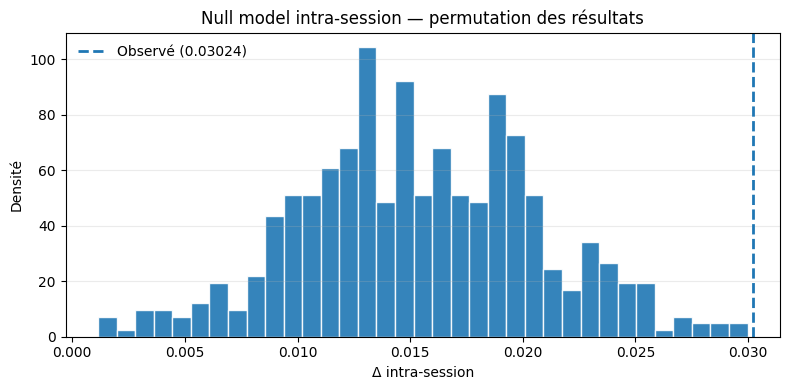

In [22]:
SEED = 0
N_SIM = 500 
rng = np.random.default_rng(SEED)

df_sim = (
    df_intra[["user_id", "session_id", "date", "win"]]
    .dropna()
    .sort_values(["user_id", "session_id", "date"])
    .reset_index(drop=True)
)

def compute_delta(df, col="win"):
    win_next = df.groupby(["user_id", "session_id"], sort=False)[col].shift(-1)
    tmp = df.assign(win_next=win_next).dropna(subset=["win_next"])
    return (
        tmp.loc[tmp[col] == 1, "win_next"].mean()
        - tmp.loc[tmp[col] == 0, "win_next"].mean()
    )

real_delta = compute_delta(df_sim, col="win")

idx_by_group = [
    g.index.to_numpy()
    for _, g in df_sim.groupby(["user_id", "session_id"], sort=False)
]

wins = df_sim["win"].to_numpy()
sim_deltas = np.empty(N_SIM)

for i in range(N_SIM):
    shuffled = wins.copy()
    for idx in idx_by_group:
        shuffled[idx] = rng.permutation(shuffled[idx])
    df_sim["win_perm"] = shuffled
    sim_deltas[i] = compute_delta(df_sim, col="win_perm")

df_sim.drop(columns=["win_perm"], inplace=True)

#résultats
p_val = (sim_deltas >= real_delta).mean()
real_delta, p_val
print(f"Δ observé (intra-session) = {real_delta:.5f}")
print(f"p-value (permutation intra-session) < {1/N_SIM:.3f}" if p_val == 0 else f"p-value = {p_val:.4f}")

#histogramme
plt.figure(figsize=(8,4))
plt.hist(sim_deltas, bins=35, density=True, alpha=0.9, edgecolor="white")
plt.axvline(real_delta, linestyle="--", linewidth=2, label=f"Observé ({real_delta:.5f})")
plt.xlabel("Δ intra-session")
plt.ylabel("Densité")
plt.title("Null model intra-session — permutation des résultats")
plt.legend(frameon=False)
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


La distribution issue des permutations est fortement concentrée autour de 0,015, tandis que la valeur observée de la statistique se situe nettement dans la queue droite de cette distribution, autour de 0,030.

Aucune permutation ne produit une valeur aussi élevée (p-value < 0,002), ce qui indique l’existence d’une dépendance locale entre résultats consécutifs au sein des sessions.

Le Δ est globalement positif, ce qui reflète un taux de victoire moyen légèrement supérieur à 50 %. Cette asymétrie s’explique par la sélection d’un sous-ensemble de joueurs plutôt que l’ensemble de la plateforme, en particulier des joueurs plus actifs et engagés, caractérisés par des sessions comportant un nombre élevé de parties. Cette caractéristique est conservée dans le null model et n’affecte pas l’interprétation des dépendances conditionnelles étudiées.

### V.5 Conclusion de la section

Les contrôles montrent que l’association entre victoire récente et probabilité de victoire suivante persiste après prise en compte du niveau du joueur et de la couleur, ce qui suggère qu’elle ne se réduit pas à des facteurs structurels simples.

Les analyses complémentaires pointent des mécanismes plausibles (légère tendance à répéter une stratégie après une victoire, dynamique de session compatible avec fatigue/relâchement), cohérents avec une dépendance à court terme au sein des sessions.

Enfin, le test de permutation intra-session, qui conserve pour chaque joueur et chaque session le nombre de victoires et la longueur des sessions tout en randomisant l’ordre des résultats, rejette l’hypothèse d’une absence de dépendance temporelle (p-value < 0,002). Cela confirme que l’effet détecté ne provient pas uniquement de la composition des sessions ou des différences de niveau, mais d’une dynamique locale entre parties consécutives.

Au total, les résultats sont compatibles avec une dynamique temporelle réelle mais subtile, proche d’un Hot Hand limité à court terme, sans implication causale stricte.


## Conclusion générale

Ce notebook a étudié l’existence d’un effet de *Hot Hand* dans des parties d’échecs en ligne,
défini comme une augmentation de la probabilité de gagner une partie après une victoire récente.

Les résultats montrent d’abord une dépendance nette entre résultats consécutifs : la probabilité
de victoire à N+1 est plus élevée après une victoire qu’après une défaite, et ce constat se retrouve
quel que soit le format de partie et la tranche de niveau.

Un point central de l’analyse est la prise en compte de la proximité temporelle. En restreignant
l’étude aux transitions intra-session (parties séparées de 30 minutes au plus), la dépendance
demeure hautement significative. Cela indique que l’effet observé n’est pas uniquement dû à des
parties “consécutives” mais espacées dans le temps, et qu’il s’exprime également dans des séquences
de jeu continues.

L’analyse markovienne renforce ce constat : au sein des sessions, un modèle qui tient compte des
deux résultats précédents (ordre 2) améliore significativement l’ajustement par rapport à un modèle
ne dépendant que du dernier résultat (ordre 1). Autrement dit, la dynamique intra-session ne se
réduit pas à une mémoire d’un seul match.

Par ailleurs, plusieurs contrôles suggèrent que cette dépendance ne se résume pas à des facteurs structurels
simples. Dans une régression logistique, l’association entre victoire récente et victoire suivante
persiste après contrôle du niveau du joueur et de la couleur. De plus, on observe une légère tendance
à répéter une ouverture après une victoire, compatible avec des ajustements de décision à court terme.

Enfin, le test de permutation intra-session, qui conserve pour chaque joueur et chaque session le nombre de victoires et la longueur des sessions tout en randomisant l’ordre des résultats, rejette l’hypothèse d’une absence de dépendance temporelle. Ce résultat indique que l’effet détecté ne s’explique pas uniquement par la composition des sessions ou l’hétérogénéité des joueurs, mais correspond bien à une dépendance locale entre parties consécutives au sein des sessions.

En résumé, les données sont compatibles avec l’existence d’une dynamique de performance à court terme au sein des sessions, cohérente avec une forme modérée d’effet Hot Hand. Néanmoins, cette dynamique apparaît fragile et sensible au choix des outils statistiques. L’étude restant observationnelle, l’absence d’information détaillée sur l’adversaire et le score attendu limite toute interprétation causale stricte. Une extension naturelle consisterait à intégrer ces dimensions et à tester la robustesse des résultats à d’autres définitions de session et d’autres statistiques de dépendance temporelle.
